# 渋谷区分煙対策データ分析

このノートブックでは、渋谷区の分煙対策指導と過料処分の活動実績データを分析します。


In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# 日本語フォント設定
plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# プロット設定
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
    
sns.set_palette("husl")
%matplotlib inline


## データの読み込みと基本情報


In [2]:
# CSVファイルの読み込み
df = pd.read_csv('../data/131130_分煙対策_指導と過料処分の活動実績_1924926636818441489.csv')

# データの基本情報
print("データ形状:", df.shape)
print("\n列名:")
print(df.columns.tolist())
print("\nデータ型:")
print(df.dtypes)
print("\n最初の5行:")
df.head()


データ形状: (2922, 8)

列名:
['年度', '月', '日', '指導員/啓発員', 'データ種別', '値区分', '値', 'ObjectId']

データ型:
年度           int64
月            int64
日            int64
指導員/啓発員     object
データ種別       object
値区分         object
値            int64
ObjectId     int64
dtype: object

最初の5行:


,年度,月,日,指導員/啓発員,データ種別,値区分,値,ObjectId
0,2020,1,1,分煙対策指導員,指導対象,路上喫煙,0,1
1,2020,1,1,分煙対策指導員,指導対象,路上喫煙過料,0,2
2,2020,1,2,分煙対策指導員,指導対象,路上喫煙,0,3
3,2020,1,2,分煙対策指導員,指導対象,路上喫煙過料,0,4
4,2020,1,3,分煙対策指導員,指導対象,路上喫煙,0,5


In [3]:
# データの統計情報
print("基本統計情報:")
print(df.describe())

print("\n欠損値の確認:")
print(df.isnull().sum())

print("\n各カテゴリの値:")
print("指導員/啓発員:", df['指導員/啓発員'].unique())
print("データ種別:", df['データ種別'].unique())
print("値区分:", df['値区分'].unique())


基本統計情報:
                年度            月            日            値     ObjectId
count  2922.000000  2922.000000  2922.000000  2922.000000  2922.000000
mean   2021.501027     6.522930    15.729637    81.582820  1461.500000
std       1.118531     3.449293     8.801598    75.707297   843.653069
min    2020.000000     1.000000     1.000000     0.000000     1.000000
25%    2021.000000     4.000000     8.000000    18.000000   731.250000
50%    2022.000000     7.000000    16.000000    45.000000  1461.500000
75%    2023.000000    10.000000    23.000000   146.000000  2191.750000
max    2023.000000    12.000000    31.000000   592.000000  2922.000000

欠損値の確認:
年度          0
月           0
日           0
指導員/啓発員     0
データ種別       0
値区分         0
値           0
ObjectId    0
dtype: int64

各カテゴリの値:
指導員/啓発員: ['分煙対策指導員']
データ種別: ['指導対象']
値区分: ['路上喫煙' '路上喫煙過料']


## データの前処理


In [4]:
# 年度から西暦年を算出する関数（1〜3月は翌年にずらす）
def fiscal_to_calendar_year(row):
    if int(row['月']) <= 3:
        return int(row['年度']) + 1
    else:
        return int(row['年度'])

# 西暦年の列を追加
df['西暦'] = df.apply(fiscal_to_calendar_year, axis=1)

# 日付列の作成（ゼロ埋めしておくと安全）
df['日付'] = pd.to_datetime(
    df['西暦'].astype(str) + '-' +
    df['月'].astype(str).str.zfill(2) + '-' +
    df['日'].astype(str).str.zfill(2),
    errors='coerce'  # 存在しない日付は NaT に
)

# 年度と月の組み合わせ（ゼロ埋め）
df['年月'] = df['年度'].astype(str) + '-' + df['月'].astype(str).str.zfill(2)

# 無効な日付（NaT）を除外する（任意）
df = df[df['日付'].notna()]

# データの確認
print("日付範囲:", df['日付'].min(), "から", df['日付'].max())
print("総期間:", (df['日付'].max() - df['日付'].min()).days, "日間")

df.head()

日付範囲: 2020-04-01 00:00:00 から 2024-03-31 00:00:00
総期間: 1460 日間


,年度,月,日,指導員/啓発員,データ種別,値区分,値,ObjectId,西暦,日付,年月
0,2020,1,1,分煙対策指導員,指導対象,路上喫煙,0,1,2021,2021-01-01,2020-01
1,2020,1,1,分煙対策指導員,指導対象,路上喫煙過料,0,2,2021,2021-01-01,2020-01
2,2020,1,2,分煙対策指導員,指導対象,路上喫煙,0,3,2021,2021-01-02,2020-01
3,2020,1,2,分煙対策指導員,指導対象,路上喫煙過料,0,4,2021,2021-01-02,2020-01
4,2020,1,3,分煙対策指導員,指導対象,路上喫煙,0,5,2021,2021-01-03,2020-01


## 時系列分析


In [5]:
# 例: IPAexゴシック（インストール済みの日本語フォントを指定）
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"  # フォントファイルのパスを指定
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()

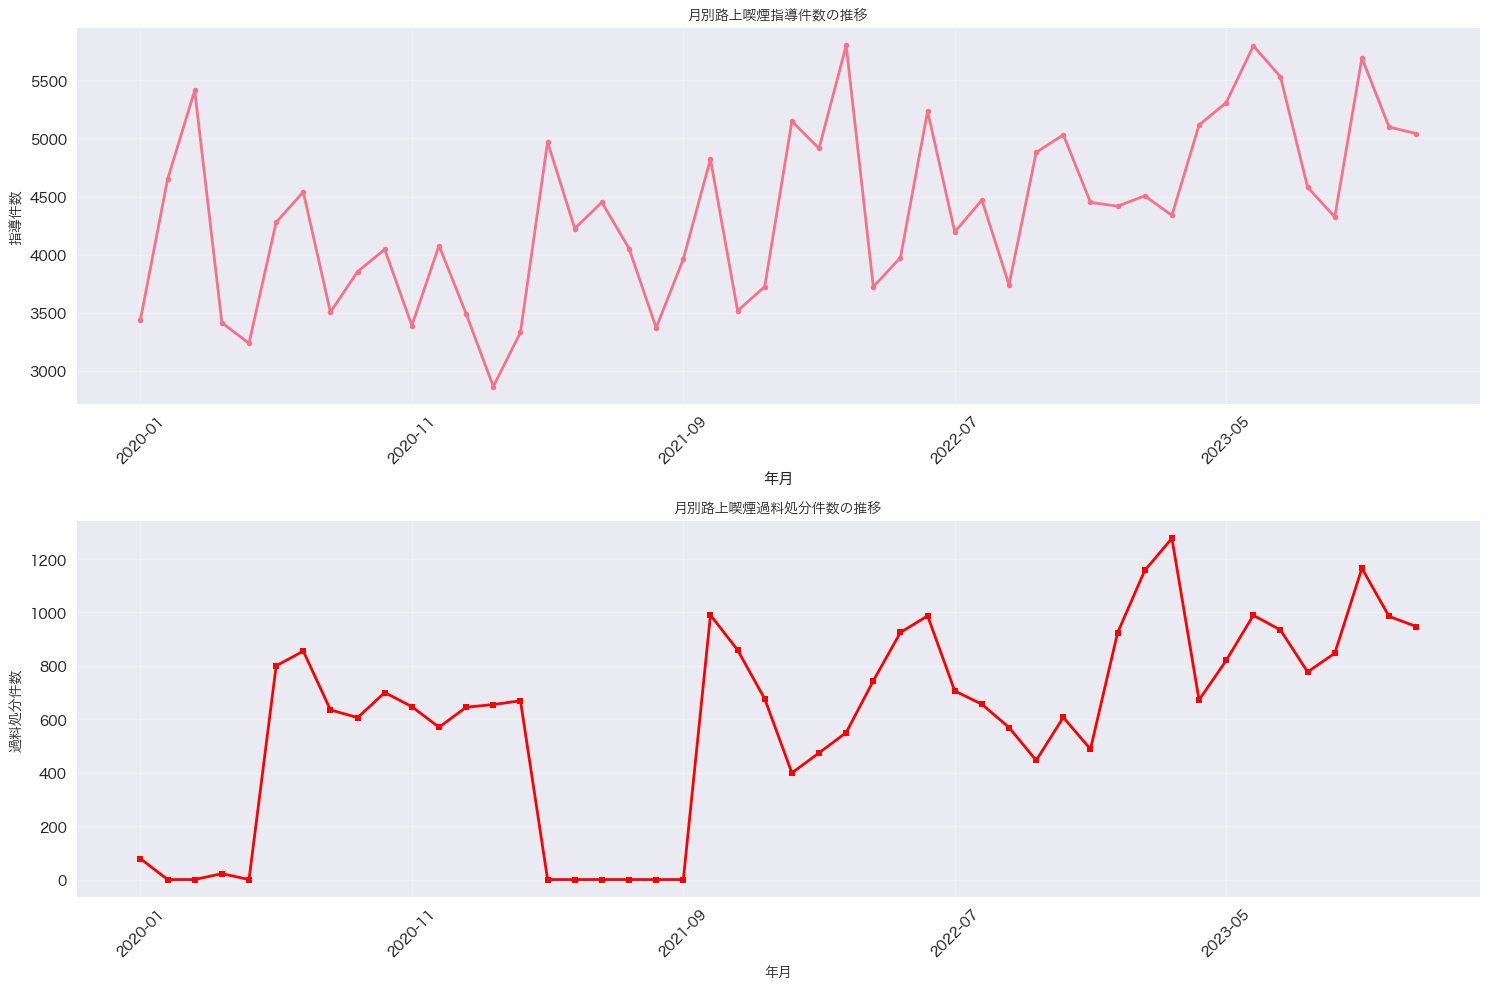

In [6]:
# 月別の指導・過料処分件数の推移
monthly_data = df.groupby(['年月', '値区分'])['値'].sum().reset_index()
monthly_pivot = monthly_data.pivot(index='年月', columns='値区分', values='値').fillna(0)

# グラフの作成
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 路上喫煙指導件数
monthly_pivot['路上喫煙'].plot(ax=ax1, marker='o', linewidth=2, markersize=4)
ax1.set_title('月別路上喫煙指導件数の推移', fontsize=14, fontweight='bold', fontproperties=font_prop)
ax1.set_ylabel('指導件数', fontproperties=font_prop)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 路上喫煙過料処分件数
monthly_pivot['路上喫煙過料'].plot(ax=ax2, marker='s', linewidth=2, markersize=4, color='red')
ax2.set_title('月別路上喫煙過料処分件数の推移', fontsize=14, fontweight='bold', fontproperties=font_prop)
ax2.set_ylabel('過料処分件数', fontproperties=font_prop)
ax2.set_xlabel('年月', fontproperties=font_prop)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

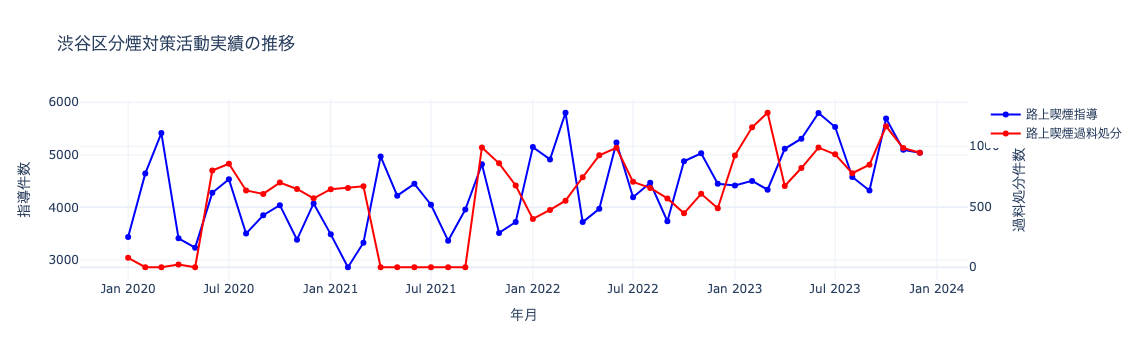

In [7]:
# インタラクティブな時系列グラフ（Plotly）
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_pivot.index,
    y=monthly_pivot['路上喫煙'],
    mode='lines+markers',
    name='路上喫煙指導',
    line=dict(color='blue', width=2),
    marker=dict(size=6)
))

fig.add_trace(go.Scatter(
    x=monthly_pivot.index,
    y=monthly_pivot['路上喫煙過料'],
    mode='lines+markers',
    name='路上喫煙過料処分',
    line=dict(color='red', width=2),
    marker=dict(size=6),
    yaxis='y2'
))

fig.update_layout(
    title='渋谷区分煙対策活動実績の推移',
    xaxis_title='年月',
    yaxis_title='指導件数',
    yaxis2=dict(
        title='過料処分件数',
        overlaying='y',
        side='right'
    ),
    hovermode='x unified',
    template='plotly_white'
)

fig.show()


# トレンド分析

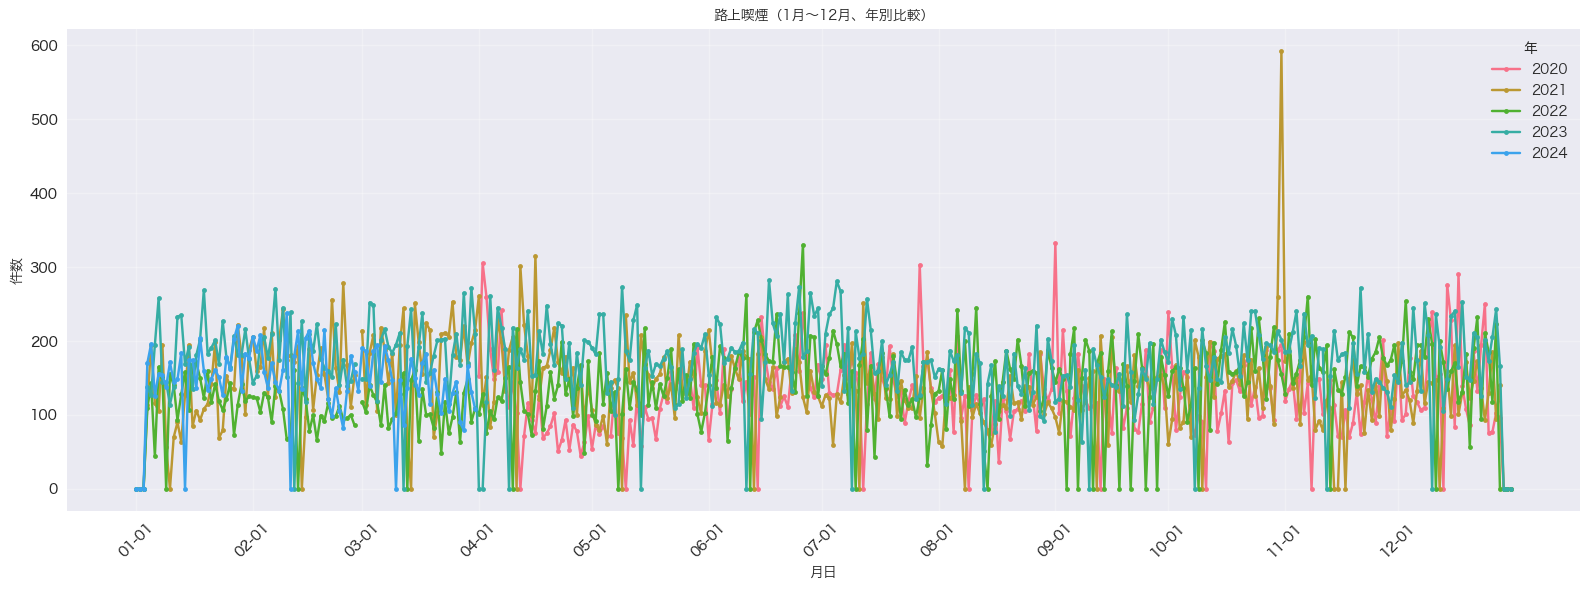

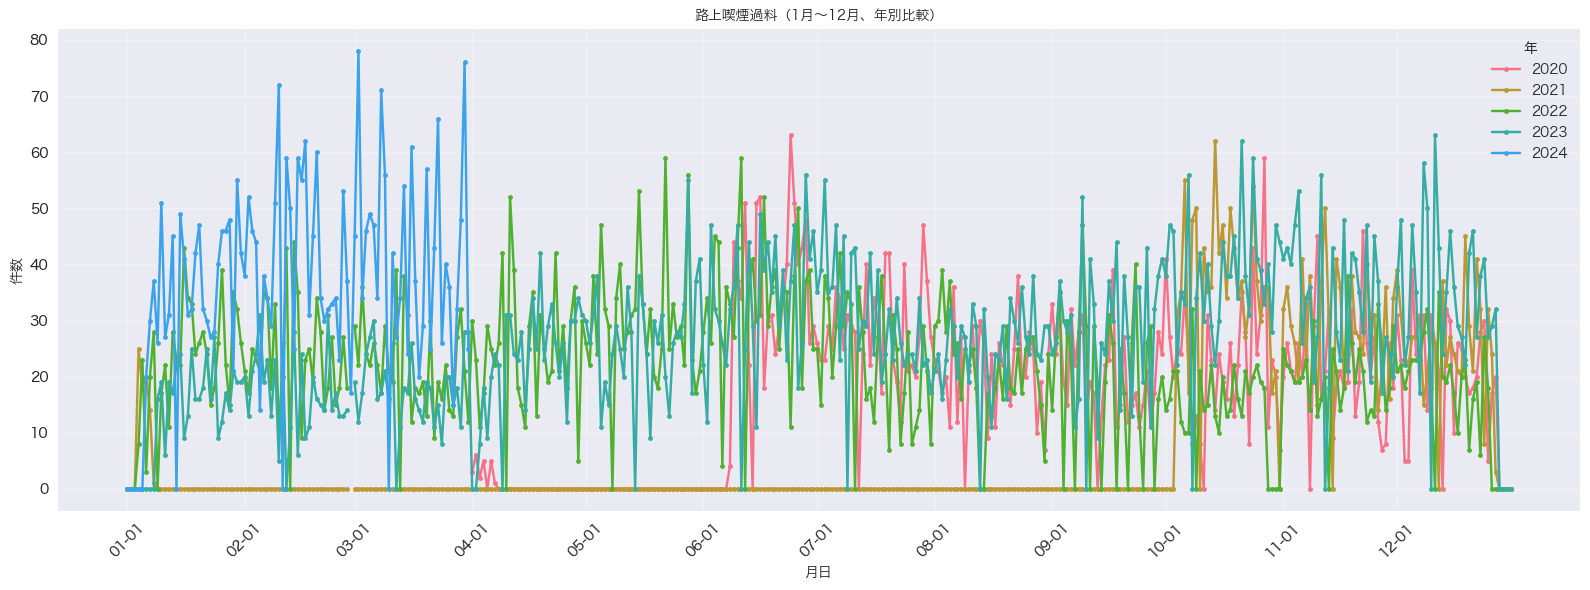

In [27]:
for category in ['路上喫煙', '路上喫煙過料']:
    pivot = df[df['値区分'] == category].pivot_table(
        index='年月日', columns='西暦', values='値', aggfunc='sum'
    ).sort_index()

    xticks_interval = 10
    xticks = [d for d in pivot.index if d.endswith('-01')]
    xtick_labels = [f"{int(d[:2])}月" for d in xticks]  # '01-01' → '1月'

    plt.figure(figsize=(16, 6))
    for year in pivot.columns:
        plt.plot(pivot.index, pivot[year], marker='.', label=str(year))

    plt.title(f'{category}（1月〜12月、年別比較）', fontsize=16, fontweight='bold', fontproperties=font_prop)
    plt.xlabel('月日', fontproperties=font_prop)
    plt.ylabel('件数', fontproperties=font_prop)
    plt.xticks(ticks=xticks, labels=xticks, rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(title='年', prop=font_prop)
    plt.tight_layout()
    plt.show()

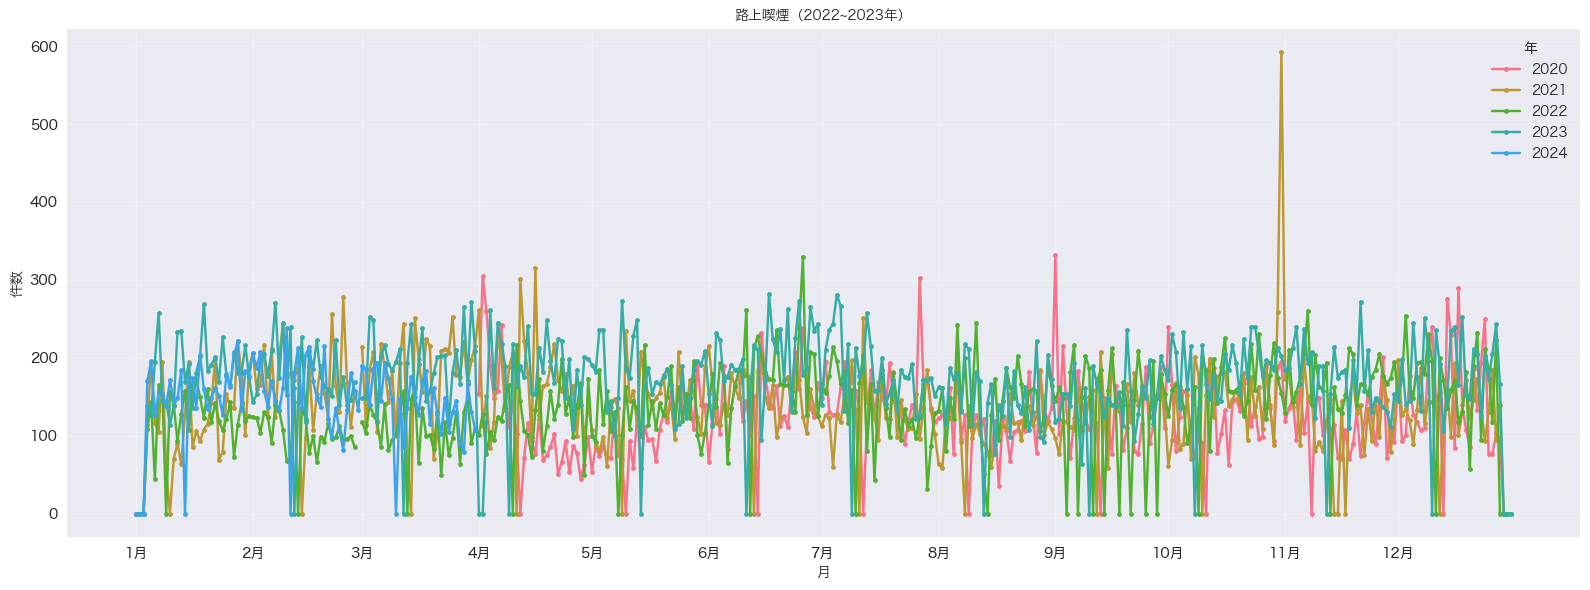

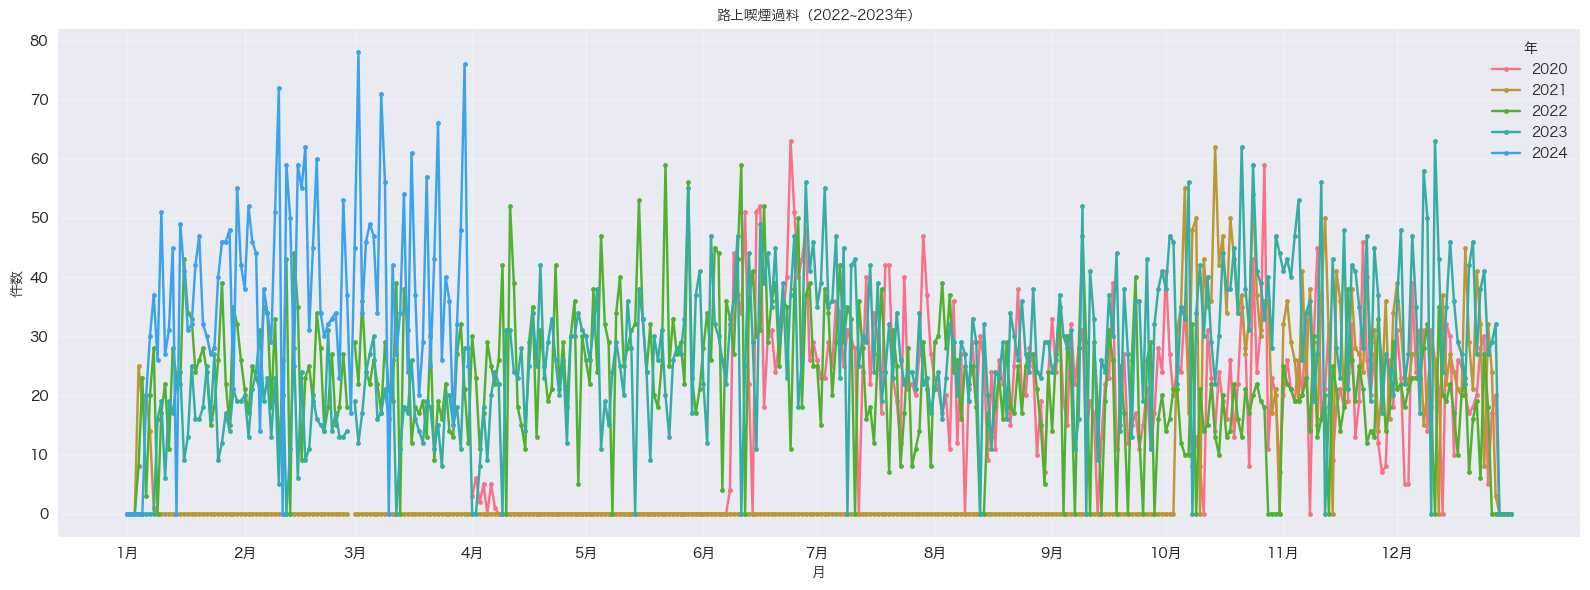

In [26]:
for category in ['路上喫煙', '路上喫煙過料']:
    pivot = df[df['値区分'] == category].pivot_table(
        index='年月日', columns='西暦', values='値', aggfunc='sum'
    ).sort_index()

    # 年度を2022〜2024に限定
    pivot = pivot[[y for y in pivot.columns if 2020 <= y <= 2024]]

    # 月初だけを抽出し、「1月」「2月」…形式に変換
    xticks = [d for d in pivot.index if d.endswith('-01')]
    xtick_labels = [f"{int(d[:2])}月" for d in xticks]

    plt.figure(figsize=(16, 6))
    for year in pivot.columns:
        plt.plot(pivot.index, pivot[year], marker='.', label=str(year))

    plt.title(f'{category}（2022~2023年）', fontsize=16, fontweight='bold', fontproperties=font_prop)
    plt.xlabel('月', fontproperties=font_prop)
    plt.ylabel('件数', fontproperties=font_prop)
    plt.xticks(ticks=xticks, labels=xtick_labels, rotation=0)
    plt.grid(True, alpha=0.3)
    plt.legend(title='年', prop=font_prop)
    plt.tight_layout()
    plt.show()

# 曜日ごとの分析

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   年度        2922 non-null   int64         
 1   月         2922 non-null   int64         
 2   日         2922 non-null   int64         
 3   指導員/啓発員   2922 non-null   object        
 4   データ種別     2922 non-null   object        
 5   値区分       2922 non-null   object        
 6   値         2922 non-null   int64         
 7   ObjectId  2922 non-null   int64         
 8   西暦        2922 non-null   int64         
 9   日付        2922 non-null   datetime64[ns]
 10  年月        2922 non-null   object        
 11  年月日       2922 non-null   object        
 12  曜日番号      2922 non-null   int32         
 13  曜日        2922 non-null   object        
 14  週         2922 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(6), object(7)
memory usage: 331.1+ KB


In [60]:
# 値区分を「路上喫煙」に絞る
df_smoking = df[df['値区分'] == '路上喫煙'].copy()

# 特定の年だけに絞る
target_year = 2023
df_year = df_smoking[df_smoking['日付'].dt.year == target_year].copy()

In [61]:
# 曜日番号と日本語曜日（すでに処理済みなら省略可）
weekday_map = {0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'}
df_year['曜日番号'] = df_year['日付'].dt.weekday
df_year['曜日'] = df_year['曜日番号'].map(weekday_map)

# 週番号（年内での週数）
df_year['週番号'] = df_year['日付'].dt.isocalendar().week
df_year['週ラベル'] = 'Week ' + df_year['週番号'].astype(str)

In [62]:
# 値の合計を曜日×週で集計
heatmap_data = df_year.pivot_table(
    index='週ラベル', columns='曜日', values='値', aggfunc='sum'
)

# 曜日を順番通りに並べる
weekday_order = ['月', '火', '水', '木', '金', '土', '日']
heatmap_data = heatmap_data.reindex(columns=weekday_order)

# 週ラベルを昇順で並べる（Week 1, Week 2, ...）
heatmap_data = heatmap_data.sort_index(key=lambda x: x.str.extract(r'(\d+)').astype(int)[0])

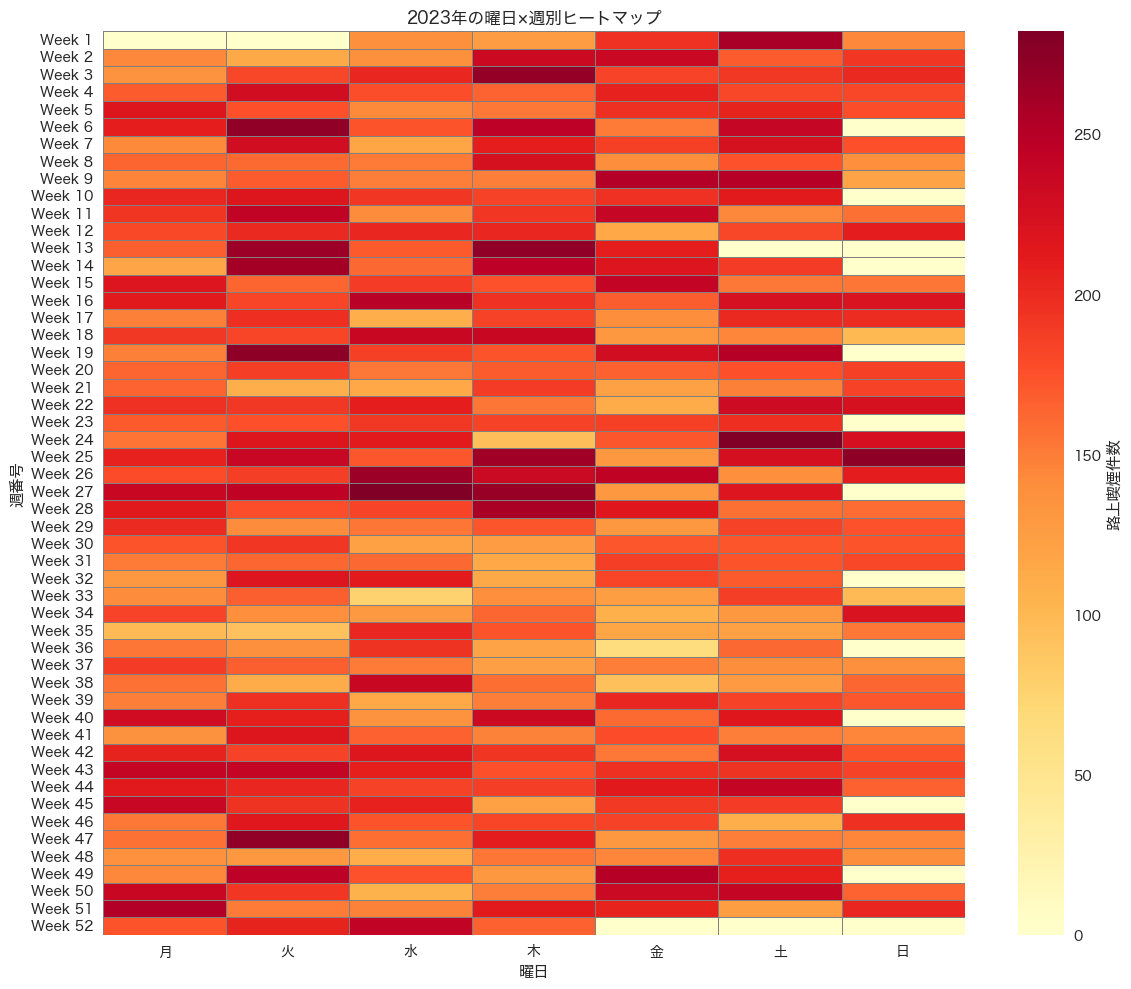

In [63]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': '路上喫煙件数'},
    annot=False
)

plt.title(f'{target_year}年の曜日×週別ヒートマップ')
plt.xlabel('曜日')
plt.ylabel('週番号')
plt.tight_layout()
plt.show()